## Online Retail Dataset
### RFM Analysis

#### Dictionary
>
<li> InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.</li>
<li> StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.</li>
<li> Description: Product (item) name. Nominal.</li>
<li> Quantity: The quantities of each product (item) per transaction. Numeric.</li>
<li> InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.</li>
<li> UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).</li>
<li> CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.</li>
<li> Country: Country name. Nominal. The name of the country where a customer resides. </li>

In [1]:
# Load Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import MinMaxScaler
import re

sns.set_palette('husl')
sns.set_context('notebook') 
sns.set_style('darkgrid')

In [2]:
data = pd.read_excel('online_retail_II.xlsx', parse_dates=['InvoiceDate'])
data['InvoiceDate'] = data['InvoiceDate'].dt.strftime('%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [3]:
data.describe(include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,525461.0,525461,522533,525461.000000,525461,525461.000000,417534.000000,525461
unique,28816.0,4632,4681,NaN,307,NaN,NaN,40
top,537434.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2009-12-14,NaN,NaN,United Kingdom
freq,675.0,3516,3549,NaN,4117,NaN,NaN,485852
mean,NaN,NaN,NaN,10.337667,NaN,4.688834,15360.645478,NaN
std,NaN,NaN,NaN,107.424110,NaN,146.126914,1680.811316,NaN
min,NaN,NaN,NaN,-9600.000000,NaN,-53594.360000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13983.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.100000,15311.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.210000,16799.000000,NaN


### Things to Note

* We will convert column names to snake case in all lower case
* Customer ID is missing quite a few values. For this analysis we will remove them since they are not relevant to our objective. 
* According to the dictionary all Invoice values that start6 with 'C' are cancelled orders. We can removes these aswell.
* Price and Quantity both have severly negative values so we may need to remove these.
* There are a lot of non unique invoice numbers. This could mean those entries may be for separate purchases. Feature engineering total purchase price may provide very useful information for any segmentation.


#### Clean columns

In [4]:
# Convert columns to lower case and replace spaces with an underscore ... This is kind of a problem with camle to snake case
data.columns = [col.lower().replace(' ', '_') for col in data.columns]

# Drop null values in the customer ID column
data.dropna(subset='customer_id', inplace=True)

# convert Customer ID to int

data['customer_id'] = data.customer_id.astype('int')

#### Removed Cancelled Orders

The website also provides information on the invoice code. If the code contains the letter 'C' then the order has been cancelled. Since we don't need these values for our analysis we can drop them.

In [5]:
data = data[~data['invoice'].astype('string').str.startswith('C')]
data.shape

(407695, 8)

#### Drop Duplicates
Next we need to check if there are any duplicates in the dataframe. If there are we only need to keep one set of them.

In [6]:
data[data.duplicated()]

# 6749 duplicated rows so we can get rid of all but the first of each instance
data.drop_duplicates(keep='first', inplace=True)
data.shape

(400946, 8)

#### Check Negative Values

In [7]:
print(data.query('price < 0'))
print(data.query('quantity < 0'))

Empty DataFrame
Columns: [invoice, stockcode, description, quantity, invoicedate, price, customer_id, country]
Index: []
Empty DataFrame
Columns: [invoice, stockcode, description, quantity, invoicedate, price, customer_id, country]
Index: []


#### Basic Feature Engineering
A really simple modification we can look at is total purchase price. It is important to look at total purchase price especially when diagnosing consumer behaviors.

In [8]:
data['total_purchase_price'] = data['quantity'] * data['price']

In [9]:
data.describe()

,quantity,price,customer_id,total_purchase_price
count,400946.000000,400946.000000,400946.000000,400946.000000
mean,13.768542,3.305566,15361.450026,21.943613
std,97.639937,35.046420,1680.669045,77.755404
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13985.000000,5.000000
50%,5.000000,1.950000,15311.000000,12.500000
75%,12.000000,3.750000,16805.000000,19.500000
max,19152.000000,10953.500000,18287.000000,15818.400000


### EDA


For a marking analysis I will start with price looking at highest and lowest priced items and then grouping them to see if they differ in various countries or for specific customers.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400946 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   invoice               400946 non-null  object 
 1   stockcode             400946 non-null  object 
 2   description           400946 non-null  object 
 3   quantity              400946 non-null  int64  
 4   invoicedate           400946 non-null  object 
 5   price                 400946 non-null  float64
 6   customer_id           400946 non-null  int64  
 7   country               400946 non-null  object 
 8   total_purchase_price  400946 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 30.6+ MB


In [11]:
data.sort_values('price', ascending=False).head(n = 10)

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,total_purchase_price
135013,502263,M,Manual,1,2010-03-23,10953.50,12918,United Kingdom,10953.50
358639,524159,M,Manual,1,2010-09-27,10468.80,14063,United Kingdom,10468.80
74356,496115,M,Manual,1,2010-01-29,8985.60,17949,United Kingdom,8985.60
129987,501768,M,Manual,1,2010-03-19,6958.17,15760,Norway,6958.17
129903,501766,M,Manual,1,2010-03-19,6958.17,15760,Norway,6958.17
288706,517483,M,Manual,1,2010-07-29,3610.50,12737,France,3610.50
358670,524162,M,Manual,1,2010-09-27,2769.90,14063,United Kingdom,2769.90
418886,529356,M,Manual,1,2010-10-28,2736.16,14156,EIRE,2736.16
394037,527258,M,Manual,1,2010-10-15,2667.88,15202,United Kingdom,2667.88
374485,525498,M,Manual,1,2010-10-05,2545.85,14156,EIRE,2545.85


>

The top 10 priced items in this dataframe all have the description 'Manual'. This is a business question we would need to ask the company to expand upon. It could possibly indicate a manual entry and conjoins purchases into one massive purchase which could change the results of any model we wanted to create. Lets see what happens if we analyze the product individually.

In [12]:
data.groupby(['stockcode','description'])['price'].agg(['sum', 'mean', 'median', 'count', 'std'])\
.sort_values('sum', ascending=False).head(n=5)


,,sum,mean,median,count,std
stockcode,description,,,,,
M,Manual,96580.69,229.407815,2.55,421,1046.946891
22423,REGENCY CAKESTAND 3 TIER,21080.15,12.429334,12.75,1696,0.746413
POST,POSTAGE,19964.83,27.052615,18.00,738,45.457751
85123A,WHITE HANGING HEART T-LIGHT HOLDER,8868.69,2.854422,2.95,3107,0.172225
21754,HOME BUILDING BLOCK WORD,7069.40,5.930705,5.95,1192,0.096349


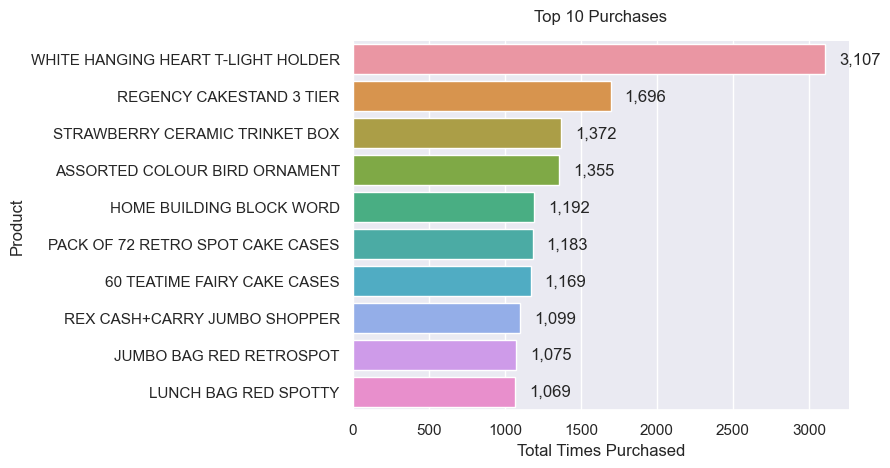

In [13]:
# Create a list of the top 10 products by most purchases
top_10_products = data.groupby(['stockcode','description'])['price'].agg(['sum', 'mean', 'median', 'count', 'std'])\
.sort_values('count', ascending=False).reset_index().head(n=10)

ax = sns.barplot(data = top_10_products, y = "description", x = 'count')
for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=10, labels=[f'{int(val):,}' for val in i.datavalues])

plt.ylabel("Product")
plt.xlabel('Total Times Purchased')
plt.title("Top 10 Purchases", y = 1.03)
sns.despine();




It may be useful to know what our top selling product are by the amount of times they've be involved in a purchase. As we can see the "White Hanging Heart T-Light Holder" is our most sold product, but what about in a single purchase. Products that are bought in bulk typically warrant a promotion and it is very useful to know what that threshold is!

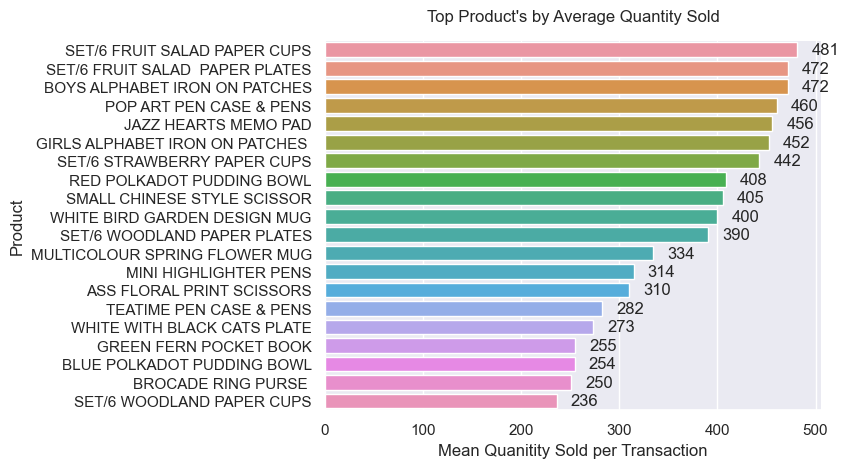

In [14]:
# Removing products that have been sold lees than 20 times as these may not be relevant to a top product comparison
s_codes = data.stockcode.value_counts()
filter_data = data[data['stockcode'].isin(s_codes[s_codes > 20].index)]

# aggregating quantities 
top_20_median_quantity = filter_data.groupby(['stockcode', 'description'])['quantity'].agg(['mean', 'median'])\
    .reset_index().sort_values('mean', ascending = False).head(n = 20) 

# Bar plot of mean transactions
ax = sns.barplot(data=top_20_median_quantity, y = 'description', x = 'mean')
sns.despine()
for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=10, labels=[f'{int(val):,}' for val in i.datavalues])
plt.xlabel('Mean Quanitity Sold per Transaction')
plt.ylabel('Product')
plt.title("Top Product's by Average Quantity Sold", y = 1.03);

plt.savefig('top_products.png', dpi=300, bbox_inches='tight')

Interesting that we have many product that average a significant amount of average purchases for most of our products. If the data provided the cost of goods sold (COGS) and we could analyze profits marging we can possibly recommend a discount for purchases over a certain amount. Ofcourse it wouldn't be wise to offer a promotion if it would be put stress on production, logistics or the profit margin wasn't high enough.

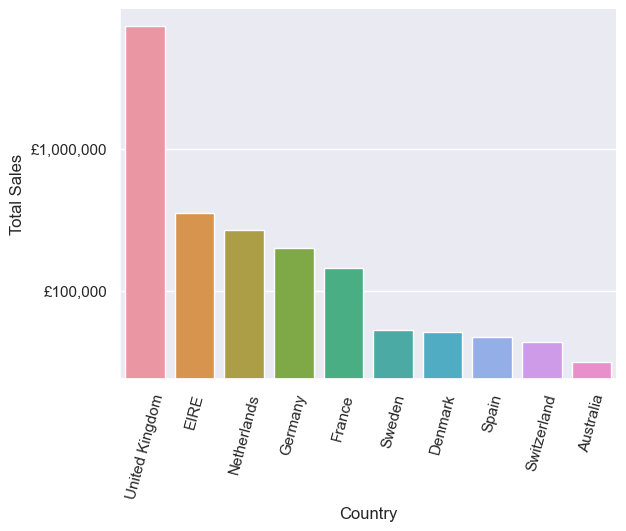

In [15]:
top10_total_spending = data.groupby('country')['total_purchase_price'].agg(['sum', 'mean', 'median', 'count'])\
.sort_values('sum', ascending=False).reset_index().head(n = 10)

sns.barplot(x = 'country', y = 'sum', data = top10_total_spending);
sns.despine()
plt.xticks(rotation = 75)
plt.xlabel('Country')
plt.ylabel('Total Sales')
# Scale logarithmically to remove
plt.yscale('log')

# create formatter to show tick labels as currency values with pound sign and commas
ax = plt.gca()
tick = mtick.StrMethodFormatter('£{x:,.0f}')

# set format of y-axis tick labels
ax.yaxis.set_major_formatter(tick)



Most of the sales take place in the UK, which we could see from the data originally. However, as we can see below nordic countries have a much higher likelihood of making large purchases. It might be worth seeing if there is a trend for those large purchases and testing some promotional opportunities in those countries.

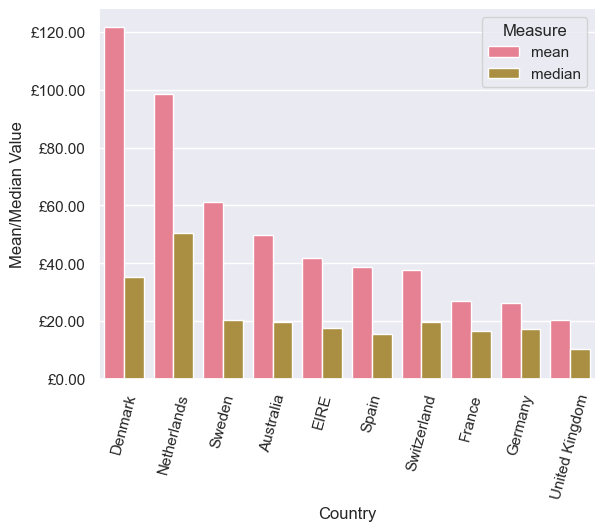

In [16]:
# pivot mean and median values longer 
top10_long = pd.melt(top10_total_spending[['country', 'mean', 'median']], id_vars=['country'], var_name = 'Measure', value_name = 'Value')


sns.barplot(x = 'country', y = 'Value', data = top10_long.sort_values(by='Value', ascending=False), hue='Measure');
sns.despine()
plt.xticks(rotation = 75)
plt.xlabel('Country')
plt.ylabel('Mean/Median Value')
# create formatter to show tick labels as currency values with pound sign and commas
ax = plt.gca()
tick = mtick.StrMethodFormatter('£{x:,.2f}')

# set format of y-axis tick labels
ax.yaxis.set_major_formatter(tick)




In [17]:
data_agg_table = data.groupby(['customer_id', 'country']).agg({'total_purchase_price': ['sum', 'median'],
                                  'invoice': ['count'],
                                  'invoicedate': ['min', 'max']})

data_agg_table.sort_values(('invoice','count'),ascending=False).head(n=20)

total_purchase_price         invoice invoicedate  \
                                            sum  median   count         min   
customer_id country                                                           
14911       EIRE                      152121.22   17.70    5568  2009-12-01   
17841       United Kingdom             29562.02    3.30    4944  2009-12-02   
14606       United Kingdom             18482.10    2.95    3802  2009-12-03   
14156       EIRE                      196549.74   17.85    2646  2009-12-01   
12748       United Kingdom             22457.90    3.75    2532  2009-12-04   
17850       United Kingdom             51208.87   17.40    2499  2009-12-05   
16549       United Kingdom              8746.90    2.55    2168  2010-03-28   
15311       United Kingdom             55942.74    5.95    2038  2009-12-01   
14646       Netherlands               248396.50  103.68    1774  2009-12-02   
14527       United Kingdom             19257.08    7.50    1725  2009-12-02   
16782       United Kingdom              7732.37    2.95    1546  2009-12-09   
13089       United Kingdom             57885.45   23.40    1543  2009-12-02   
17377       United Kingdom             14174.25    5.85    1343  2009-12-02   
13081       United Kingdom             30867.77   15.60    1330  2009-12-08   
15005       United Kingdom              7681.71    5.00    1303  2009-12-01   
15039       United Kingdom             19960.30    7.95    1272  2009-12-10   
14298       United Kingdom             39667.19   25.44    1227  2009-12-11   
15768       United Kingdom             14687.06    7.95    1181  2009-12-03   
13564       United Kingdom             15310.35   10.50    1159  2009-12-02   
17448       United Kingdom             14523.67   12.72    1115  2010-03-04   

                                        
                                   max  
customer_id country                     
14911       EIRE            2010-12-09  
17841       United Kingdom  2010-12-09  
14606       United Kingdom  2010-12-08  
14156       EIRE            2010-12-03  
12748       United Kingdom  2010-12-09  
17850       United Kingdom  2010-12-02  
16549       United Kingdom  2010-11-07  
15311       United Kingdom  2010-12-09  
14646       Netherlands     2010-11-30  
14527       United Kingdom  2010-12-09  
16782       United Kingdom  2010-12-09  
13089       United Kingdom  2010-12-06  
17377       United Kingdom  2010-12-09  
13081       United Kingdom  2010-12-03  
15005       United Kingdom  2010-12-08  
15039       United Kingdom  2010-12-06  
14298       United Kingdom  2010-11-29  
15768       United Kingdom  2010-08-20  
13564       United Kingdom  2010-12-06  
17448       United Kingdom  2010-07-30

* After sorting by the customers with the most purchases we can see that the majority of purchases come from England and Ireland. There is also a very important customer from the Netherlands. 
* If we look at the top customer based on total spending (*below) we can see the Norwegian customer. It also looks like all of his purchases were on the same day. We would have to ask if that was an input error.
* There is another customer that tops the list with only one purchase that we would have to question


Lastly lets take a quick glimpse at our total sales by date. This will give us a better idea of what to expected when we start to group by cohort, plus any seaonality trends and anomalistic behaviors.
As you can see below we calculated the sum of sales for each day and then calculated the rolling weekly and monthly average to make a smooth trend line.
It is very tough to tell whether these trend are seasonal (more purchases for the holidays) since we only have one year of data.

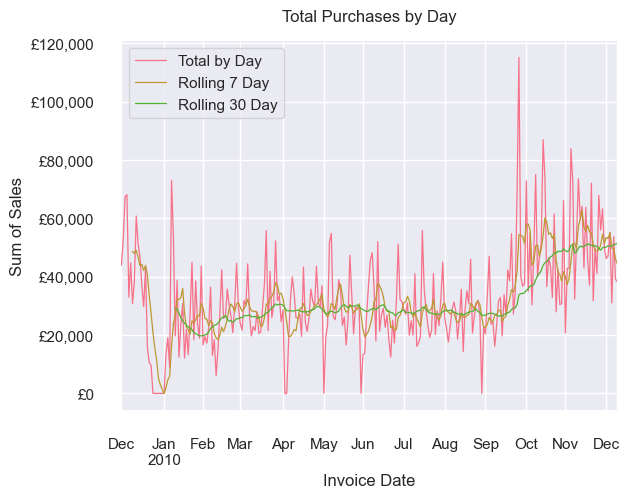

In [18]:
# Create a times series dtaa frame and calculate rolling weekly and monthly averages for the sum of purchases by day
data_ts = data.sort_values('invoicedate').set_index(pd.to_datetime(data['invoicedate']))
total_price_ts = data_ts['total_purchase_price'].to_frame()
total_price_ts = total_price_ts.resample('b').sum()
total_price_ts['rolling_7'] = total_price_ts['total_purchase_price'].rolling(7).mean()
total_price_ts['rolling_30'] = total_price_ts['total_purchase_price'].rolling(30).mean()

# Plot the time series
total_price_ts.plot(linewidth = .9); 
plt.xlabel('Invoice Date')
plt.ylabel('Sum of Sales')
plt.title('Total Purchases by Day',y = 1.03)
plt.legend(['Total by Day', 'Rolling 7 Day', 'Rolling 30 Day'])
sns.despine(offset=10, trim=True);

# set format of y-axis tick labels
ax = plt.gca()
tick = mtick.StrMethodFormatter('£{x:,.0f}')
ax.yaxis.set_major_formatter(tick);

plt.savefig('total_purchases_by_day.png', dpi=300, bbox_inches='tight')

You may have noticed a few days with 0 sales recorded. If we were to subset these dates we would see that they coordianted to holidays and likely days the business was closed.

### RFM Analysis

There are many other features to this dataset that we can explore. Here I will continue with a Cohort and RFM analysis. These two processes can be used conjointly to gain a comprehensive understanding of customer behavior. The results will provide actionable metrics that we can use to increase retention and revenue.

First we will conduct a RFM (Recency, Frequency, Monetary Value) analysis. We will do this first because an RFM analysis allows us to designated certain characteristics and value to particular groups of customers. It can be used to identify customers who may be at risk of churn. This process is also typically used for feature engineering in certain type of models.

* Recency: Time since last transaction
* Frequency: Number of purrchases in an observered period of time. This is typically a year, which we will use in this case.
* Monetary Value: Total amount spent in observed period 
* Tenure: Time since the customers first purchase. This is an extra measure that is popular to segment customers long term loyalty

Let's Begin!

In [19]:
data.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,total_purchase_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085,United Kingdom,30.0


#### RFMT

In [20]:
# C reate a second invoice column so I can quickly write lambda functions on both 
data['invoicedate'] = pd.to_datetime(data['invoicedate'])

data['invoicedate2'] = data.invoicedate

# Get the current date then group by customer and calculate the amount of days since the last transaction
current_date = data.invoicedate.max()


grouped = data.groupby('customer_id').agg({'invoicedate': lambda x: (current_date - x.max()).days, #recency
                                           'invoicedate2': lambda x : (current_date - x.min()).days, #tenure
                                          'invoice': 'count', #frequency
                                          'total_purchase_price': 'sum', # monetary
                                          })
# rename columns
grouped.rename(columns = {'invoicedate': 'recency',
            'invoicedate2': 'tenure',
            'invoice': 'frequency',
            'total_purchase_price': 'monetary'}, inplace=True)


grouped.shape

(4314, 4)

After creating the columns for RFM values we will split the columns into customized bins based on the spread of the data for each category. First we will have to decide the size of the groups. For that we can bases it on the range of values. for each of the columns for that we can create a histogram of the distributions for each value

In [21]:
def hist_plots(col):
    """
    function to plot histograms for each column in grouped
    Parameters:
    col: feature in dataframe; must be numeric
    """
    x,y,z = np.percentile(grouped[col], [25, 50, 75])
    sns.displot(data = grouped, x = col)

    plt.axvline(x=x, color = 'cyan')
    plt.axvline(x=y, color = 'cyan')
    plt.axvline(x=z, color = 'cyan')
    plt.show();
    print(f"25 Percentile: {x}")
    print(f"50 Percentile: {y}")
    print(f"75 Percentile: {z}")

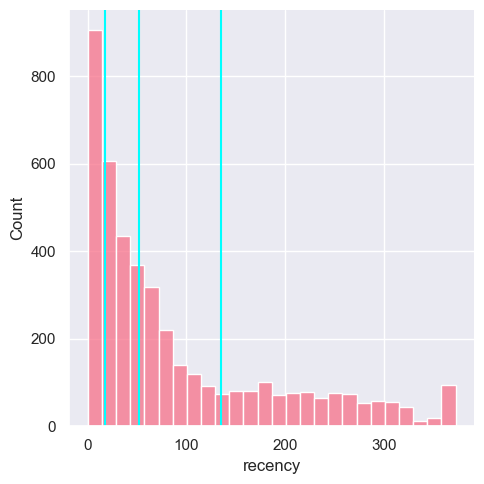

25 Percentile: 17.0
50 Percentile: 52.0
75 Percentile: 135.0


In [22]:
hist_plots('recency')

The recency feature we will slice into 4 categories. Since there is a heavy skew we will need to log transform the values to approximate a normal distribution for clustering with kmeans which we will do later. The lower the recency the higher the score. For the rest of the variables it will be the other way around.

In [23]:
# create bins and labels. lower the recency the higher the score.
r_labels = range(4,0,-1)
grouped['r'] = pd.qcut(grouped['recency'], 4, labels=r_labels)

grouped['r'].value_counts()

3    1101
4    1089
1    1078
2    1046
Name: r, dtype: int64

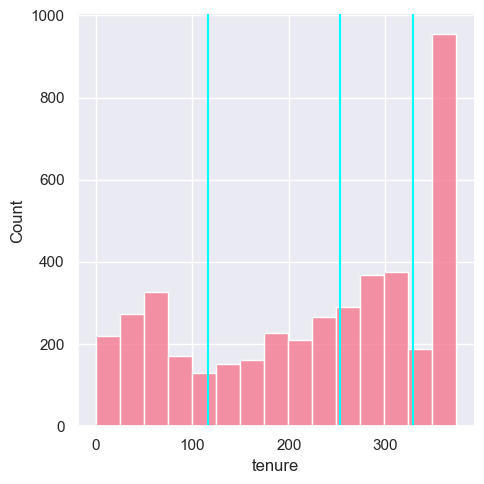

25 Percentile: 116.0
50 Percentile: 252.5
75 Percentile: 328.0


In [24]:
hist_plots('tenure')

There isn't a major difference for tenure. Instead of creating specialized bins we will divide tenure by quantiles. This will put an even number of people in each of the bins.

In [25]:
# create labels for tenure. the higher the tenure the higher the score
t_labels = range(1,5)
grouped['t'] = pd.qcut(grouped['tenure'], 4, labels=t_labels)
grouped['t'].value_counts()

3    1081
1    1080
2    1077
4    1076
Name: t, dtype: int64

Both frequency and monetary need a little extra care since they both have significant skew and outliers. Unfortunately from a cleaning perspective these data points are still very valuable to the analysis. If we graph the data as it is we will not be able to see the spread of the distribution. Instead we will log tranform them both, which is something that we will need to do to cluster them in the future. 

Since the spread and variation of these distributions is significantly higher I opter for 5 grouping to better reflect these values.

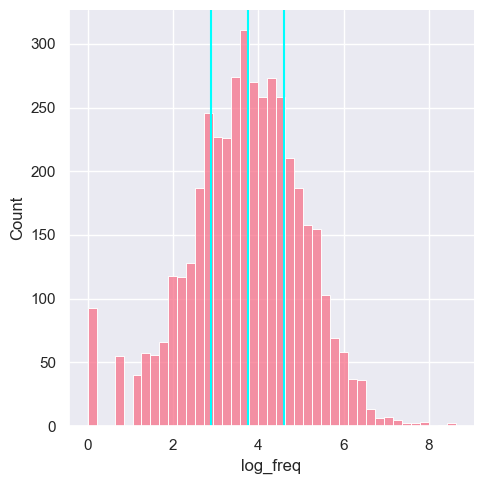

25 Percentile: 2.8903717578961645
50 Percentile: 3.7612001156935624
75 Percentile: 4.605170185988092


In [26]:
grouped['log_freq'] = np.log(grouped['frequency'])

hist_plots('log_freq')

In [27]:
# set labels for frequency and group them
f_labels = range(1,6)

grouped['f'] = pd.qcut(grouped['frequency'], 5, labels=f_labels)

grouped['f'].value_counts()

1    917
4    863
3    859
5    854
2    821
Name: f, dtype: int64

/Users/laffer/Desktop/IoD/iod_env/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


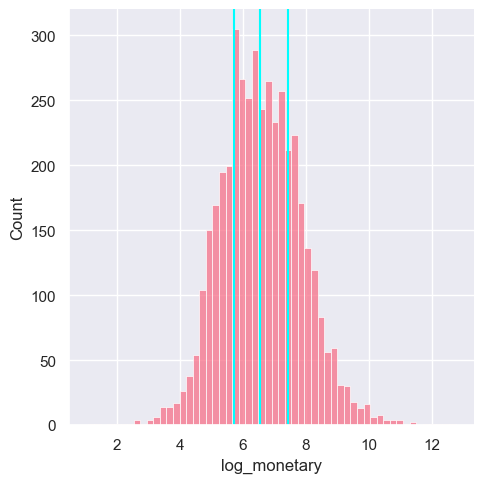

25 Percentile: 5.727189708258218
50 Percentile: 6.551657259216707
75 Percentile: 7.4454204704893066


In [28]:
# setting monetary segments
grouped['log_monetary'] = np.log(grouped['monetary'])

hist_plots('log_monetary')



In [29]:
m_lables = range(1,6)
grouped['m'] = pd.qcut(grouped['monetary'], 5, m_lables)
grouped['m'].value_counts()

1    863
2    863
4    863
5    863
3    862
Name: m, dtype: int64

In [30]:
rfmt = grouped.loc[:, ['r','f', 'm','t']]
rfmt.head()

,r,f,m,t
customer_id,,,,
12346,1,3,2,4
12347,4,4,4,1
12348,2,2,1,1
12349,3,4,5,2
12351,4,2,2,1


Now that we have our values grouped we just need to add two more columns to analyze the grouping further. 

1. Create new feauture with an RFM score by summing the values and producing summary metrics.
2. We will create a new a combined column to give us segments of the combined score and produce summary metrics.
3. Use K-Means algorithm to group cluster based on summary statistics.
4. Provide actionable recommendations for each cluster.


In [31]:
# create two columns 
rfmt['score'] = rfmt[['r','f','m','t']].sum(axis=1)
rfmt['segment'] = rfmt['f'].astype('string') + rfmt['r'].astype('string') + rfmt['m'].astype('string')\
                + rfmt['t'].astype('string')
rfmt.head()

,r,f,m,t,score,segment
customer_id,,,,,,
12346,1,3,2,4,10,3124
12347,4,4,4,1,13,4441
12348,2,2,1,1,6,2211
12349,3,4,5,2,14,4352
12351,4,2,2,1,9,2421


In [32]:
rfmt.groupby('segment').size().sort_values(ascending=False)

segment
5454    238
1112    142
1113    112
1211    104
5354     91
       ... 
3453      1
5251      1
3452      1
2313      1
3352      1
Length: 313, dtype: int64

In [33]:
grouped_rfmt = grouped[['recency', 'tenure', 'frequency', 'monetary']].merge(rfmt, how='inner', left_index=True, right_index=True)

grouped_rfmt.groupby('score').agg({'recency': 'mean',
                                   'tenure': 'mean',
                                   'frequency': 'mean',
                                   'monetary': ['mean', 'count']}).round(0)



recency tenure frequency monetary      
         mean   mean      mean     mean count
score                                        
5       145.0  145.0       7.0    135.0   246
6       155.0  162.0      11.0    179.0   348
7       163.0  177.0      17.0    262.0   411
8       131.0  161.0      23.0    387.0   400
9       119.0  171.0      33.0    541.0   358
10      102.0  197.0      40.0    841.0   358
11       84.0  210.0      52.0    965.0   303
12       66.0  232.0      65.0   1213.0   305
13       62.0  251.0      82.0   1493.0   321
14       46.0  262.0     115.0   2329.0   304
15       39.0  287.0     157.0   2765.0   265
16       24.0  314.0     199.0   3443.0   237
17       17.0  345.0     248.0   5470.0   220
18        6.0  365.0     474.0  14049.0   238

In [34]:
grouped_rfmt['score'].value_counts()
print(grouped_rfmt.shape)

(4314, 10)


Lets take the scores we have created throughout this analysis and apply labels to them.

In [35]:
# Regex to replace a variable based on a combination of RF metrics
rf_seg_map = {
    r'[1][1]': 'lost',
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3][4-5]': 'loyal_customers',
    r'4[2-3]': 'promising',
    r'41': 'new_customers',
    r'4[2-3]': 'potential_loyalist',
    r'4[4-5]': 'champions'
}

In [36]:
grouped_rfmt['rf_seg'] = rfmt['r'].astype('string') + rfmt['f'].astype('string')

grouped_rfmt['rf_seg'] = grouped_rfmt['rf_seg'].replace(rf_seg_map, regex=True)

grouped_counts = grouped_rfmt['rf_seg'].value_counts().to_frame().reset_index()
grouped_counts.columns = ['Segment', 'Count']
grouped_counts

,Segment,Count
0,at_Risk,801
1,hibernating,742
2,champions,739
3,loyal_customers,502
4,lost,430
5,about_to_sleep,368
6,potential_loyalist,263
7,need_attention,231
8,cant_loose,151
9,new_customers,87


After segmenting there are distinct categories to make decision around. Since this is a small time frame the groups won't be as distinct as we may like, however we can see there are a significant amount of customers that are at risk or hibernating. This means they have either purchased often or not at all but a long time ago in respect to at risk and hibernating.

* Fortunately there is a large chunk of champions and loyal customers. Both have purchased often and and frequently!
* Surprisingly there are not many new customers. These are customers that are very recent so they haven't pruchased as often.

Lets take this a steps further and create some visualizations.

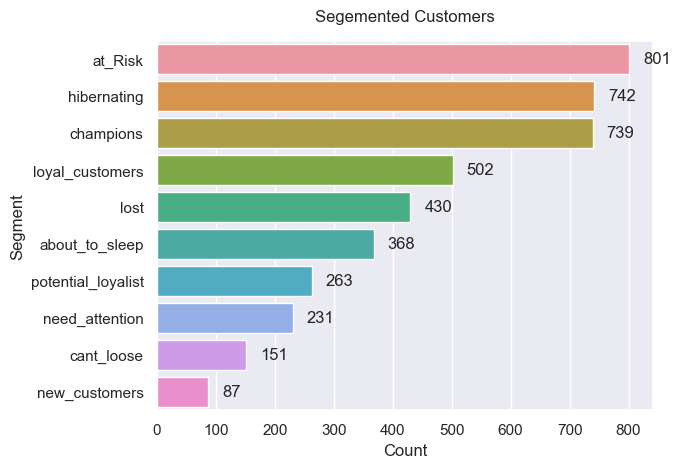

In [37]:
ax = sns.barplot(grouped_counts, x = 'Count', y = 'Segment')
for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=10, labels=[f'{int(val):,}' for val in i.datavalues])
plt.title('Segemented Customers', y=1.03);


/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_64297/3390662217.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seg_mean = grouped_seg.mean().reset_index().drop(columns=['score'])


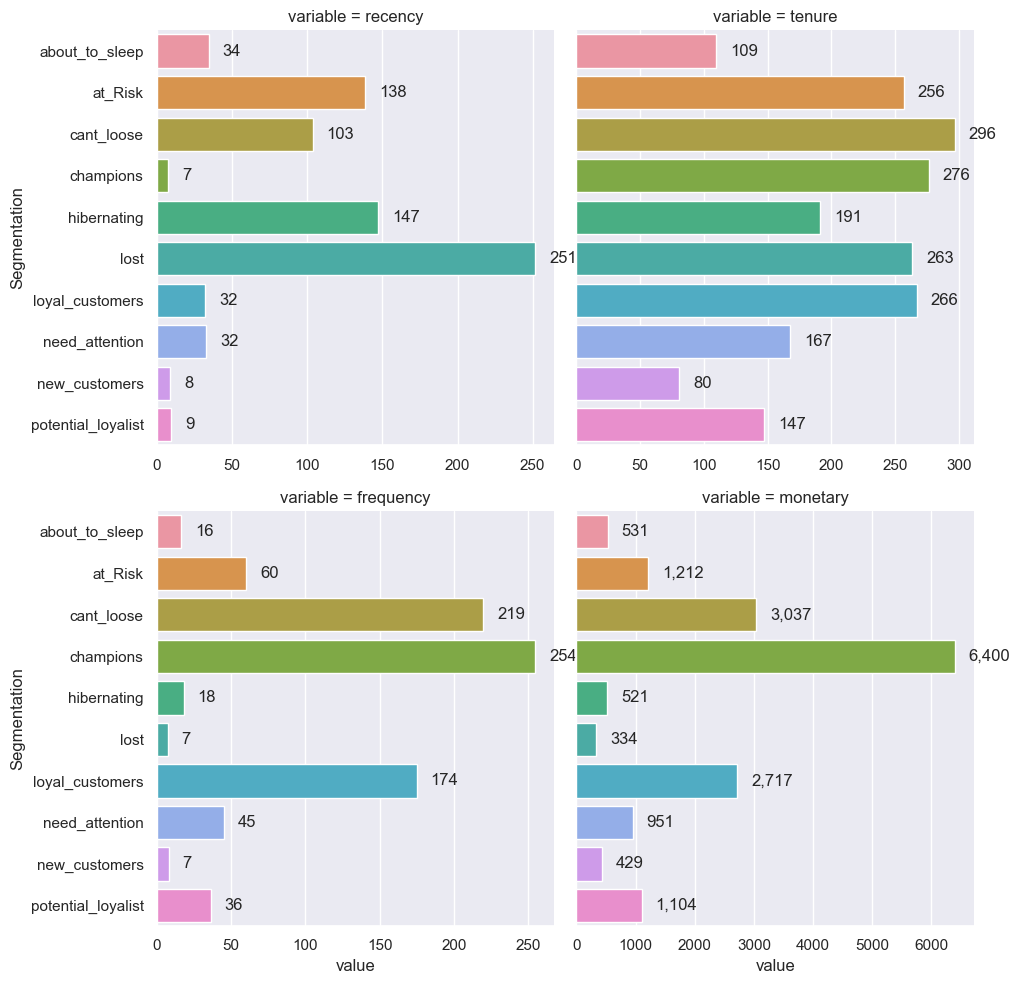

In [38]:
grouped_seg = grouped_rfmt.groupby('rf_seg')

# manipulating df
seg_mean = grouped_seg.mean().reset_index().drop(columns=['score'])

seg_mean_long = seg_mean.melt(id_vars='rf_seg')

seg_mean_long.value_counts()
# define a functino to plot the average of each of the columns by segmented group
g = sns.catplot(seg_mean_long, x = 'value', y = 'rf_seg', kind = 'bar',col = 'variable', col_wrap=2, sharex=False)
g.set(ylabel='Segmentation')
for ax in g.axes.flat:
    for i, container in enumerate(ax.containers):
        labels = [f"{int(val):,}" for val in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='edge', padding=10);



/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_64297/301709944.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seg_mean = grouped_seg.mean().reset_index().drop(columns=['score'])


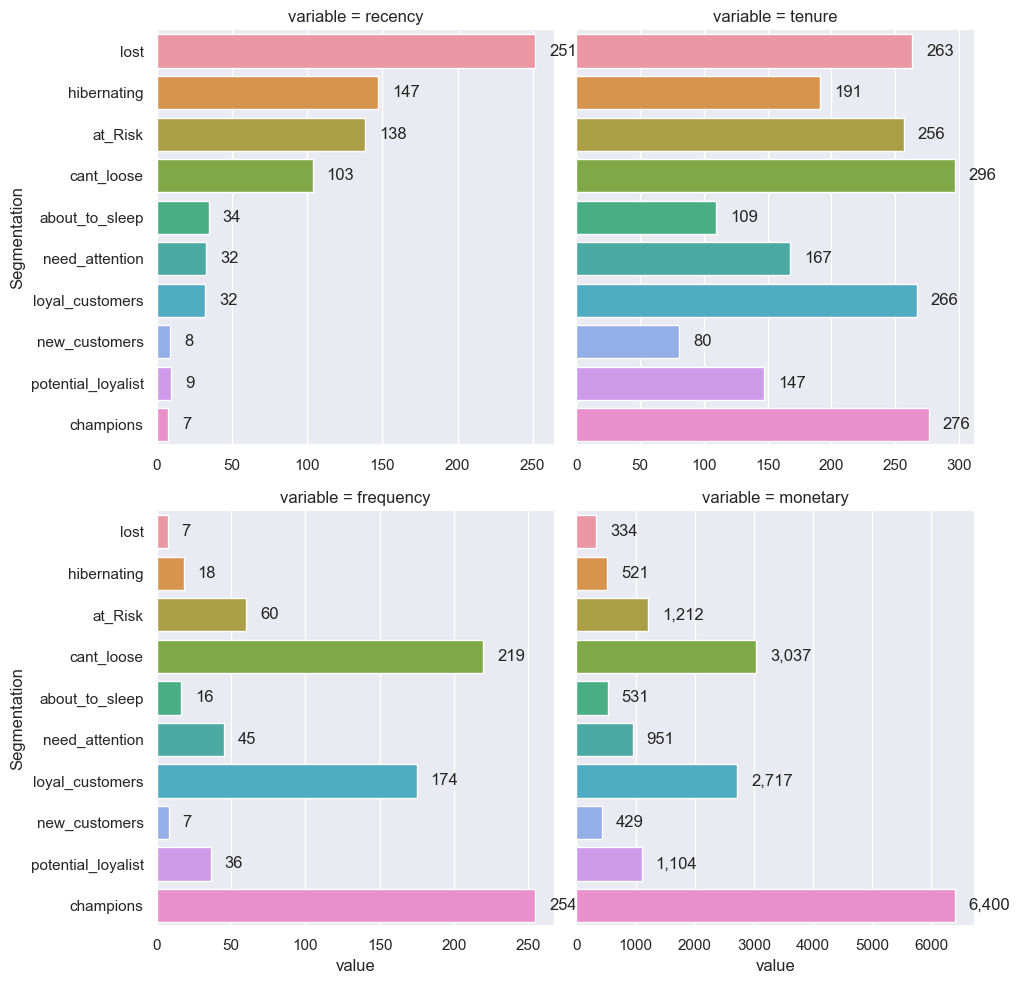

In [41]:
grouped_seg = grouped_rfmt.groupby('rf_seg')

# manipulating df
seg_mean = grouped_seg.mean().reset_index().drop(columns=['score'])

# define custom ordering for rf_seg column
seg_order = ['lost', 'hibernating', 'at_Risk', 'cant_loose', 'about_to_sleep', 
             'need_attention', 'loyal_customers', 'new_customers', 
             'potential_loyalist', 'champions']

# convert rf_seg column to categorical variable with custom ordering
seg_mean_long['rf_seg'] = pd.Categorical(seg_mean_long['rf_seg'], categories=seg_order, ordered=True)

# define a function to plot the average of each of the columns by segmented group
g = sns.catplot(seg_mean_long, x='value', y='rf_seg', kind='bar', col='variable', col_wrap=2, sharex=False)
g.set(ylabel='Segmentation')
for ax in g.axes.flat:
    for i, container in enumerate(ax.containers):
        labels = [f"{int(val):,}" for val in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='edge', padding=10);
        
        
plt.savefig('RFM.png', dpi=300, bbox_inches='tight')


Now that we have cluster we can identify who the high value customers are and improve customer retentions by targeting customers on the verge of churning.

The next points of this analysis will focus on the following:

- Target marketing campaigns: RFM segmentation helps businesses to target marketing campaigns more effectively. For example, customers who have made a purchase recently but are infrequent buyers might respond well to offers that incentivize them to purchase more frequently. On the other hand, customers who are frequent purchasers but haven't made a purchase in a while might respond well to offers that encourage them to return.

- Improve product offerings: By analyzing the purchase behavior of different customer segments, businesses can gain insights into the types of products and services that are most popular among different customer groups. This information can be used to improve product offerings and develop new products that are more likely to appeal to different customer segments.


In [72]:
# Create a dataframe
df = pd.merge(data, grouped_rfmt[['rf_seg']], left_on='customer_id', right_index=True)



group_count = df.groupby(['country','rf_seg'])['customer_id'].count().\
                        to_frame('count').reset_index()
group_count.head(2)

,country,rf_seg,count
0,Australia,about_to_sleep,42
1,Australia,at_Risk,108


In [77]:
group_count.query('rf_seg == "champions"').sort_values('count', ascending=False).head(10)

,country,rf_seg,count
149,United Kingdom,champions,167916
43,EIRE,champions,8214
64,Germany,champions,4289
55,France,champions,3067
92,Netherlands,champions,1774
117,Spain,champions,389
108,Portugal,champions,352
2,Australia,champions,293
99,Norway,champions,286
79,Italy,champions,270


Remember our champions were the customers the are the most frequent, bought recently and spent a lot of money! It is important to see that many different countries are ranked as champions.

In [79]:
group_count.query('rf_seg == "potential_loyalist"').sort_values('count', ascending=False).head(10)

,country,rf_seg,count
155,United Kingdom,potential_loyalist,8961
111,Portugal,potential_loyalist,108
97,Netherlands,potential_loyalist,86
85,Japan,potential_loyalist,76
7,Australia,potential_loyalist,63
13,Austria,potential_loyalist,58
61,France,potential_loyalist,55
87,Korea,potential_loyalist,43
31,Channel Islands,potential_loyalist,32
122,Spain,potential_loyalist,25


In [80]:
group_count.query('rf_seg == "need_attention"').sort_values('count', ascending=False).head(10)

,country,rf_seg,count
153,United Kingdom,need_attention,9355
22,Belgium,need_attention,239
81,Italy,need_attention,178
68,Germany,need_attention,156
59,France,need_attention,141
130,Sweden,need_attention,88
96,Netherlands,need_attention,55
105,Poland,need_attention,54
145,United Arab Emirates,need_attention,51
5,Australia,need_attention,49


Belgium and Italy are not a countries on either of our champions list or potential loyalist list(except Italy at #10 on champions. We need to provide a promotion to these countries sinces the list provides customers likely to churn. To identify the monetary cost of losing these customers we can identify the how much these customers have spent.

In [85]:
belg_italy = df.query('rf_seg == "need_attention" & (country == "Belgium" | country == "Italy")')
belg_italy.groupby('country')['total_purchase_price'].sum()

country
Belgium    4749.87
Italy      4710.64
Name: total_purchase_price, dtype: float64

The last thing we will do is create a visualization to sum up the information here by country. RFM analysis can't be grouped with other important demographics depending on the situation. Here we just show country.

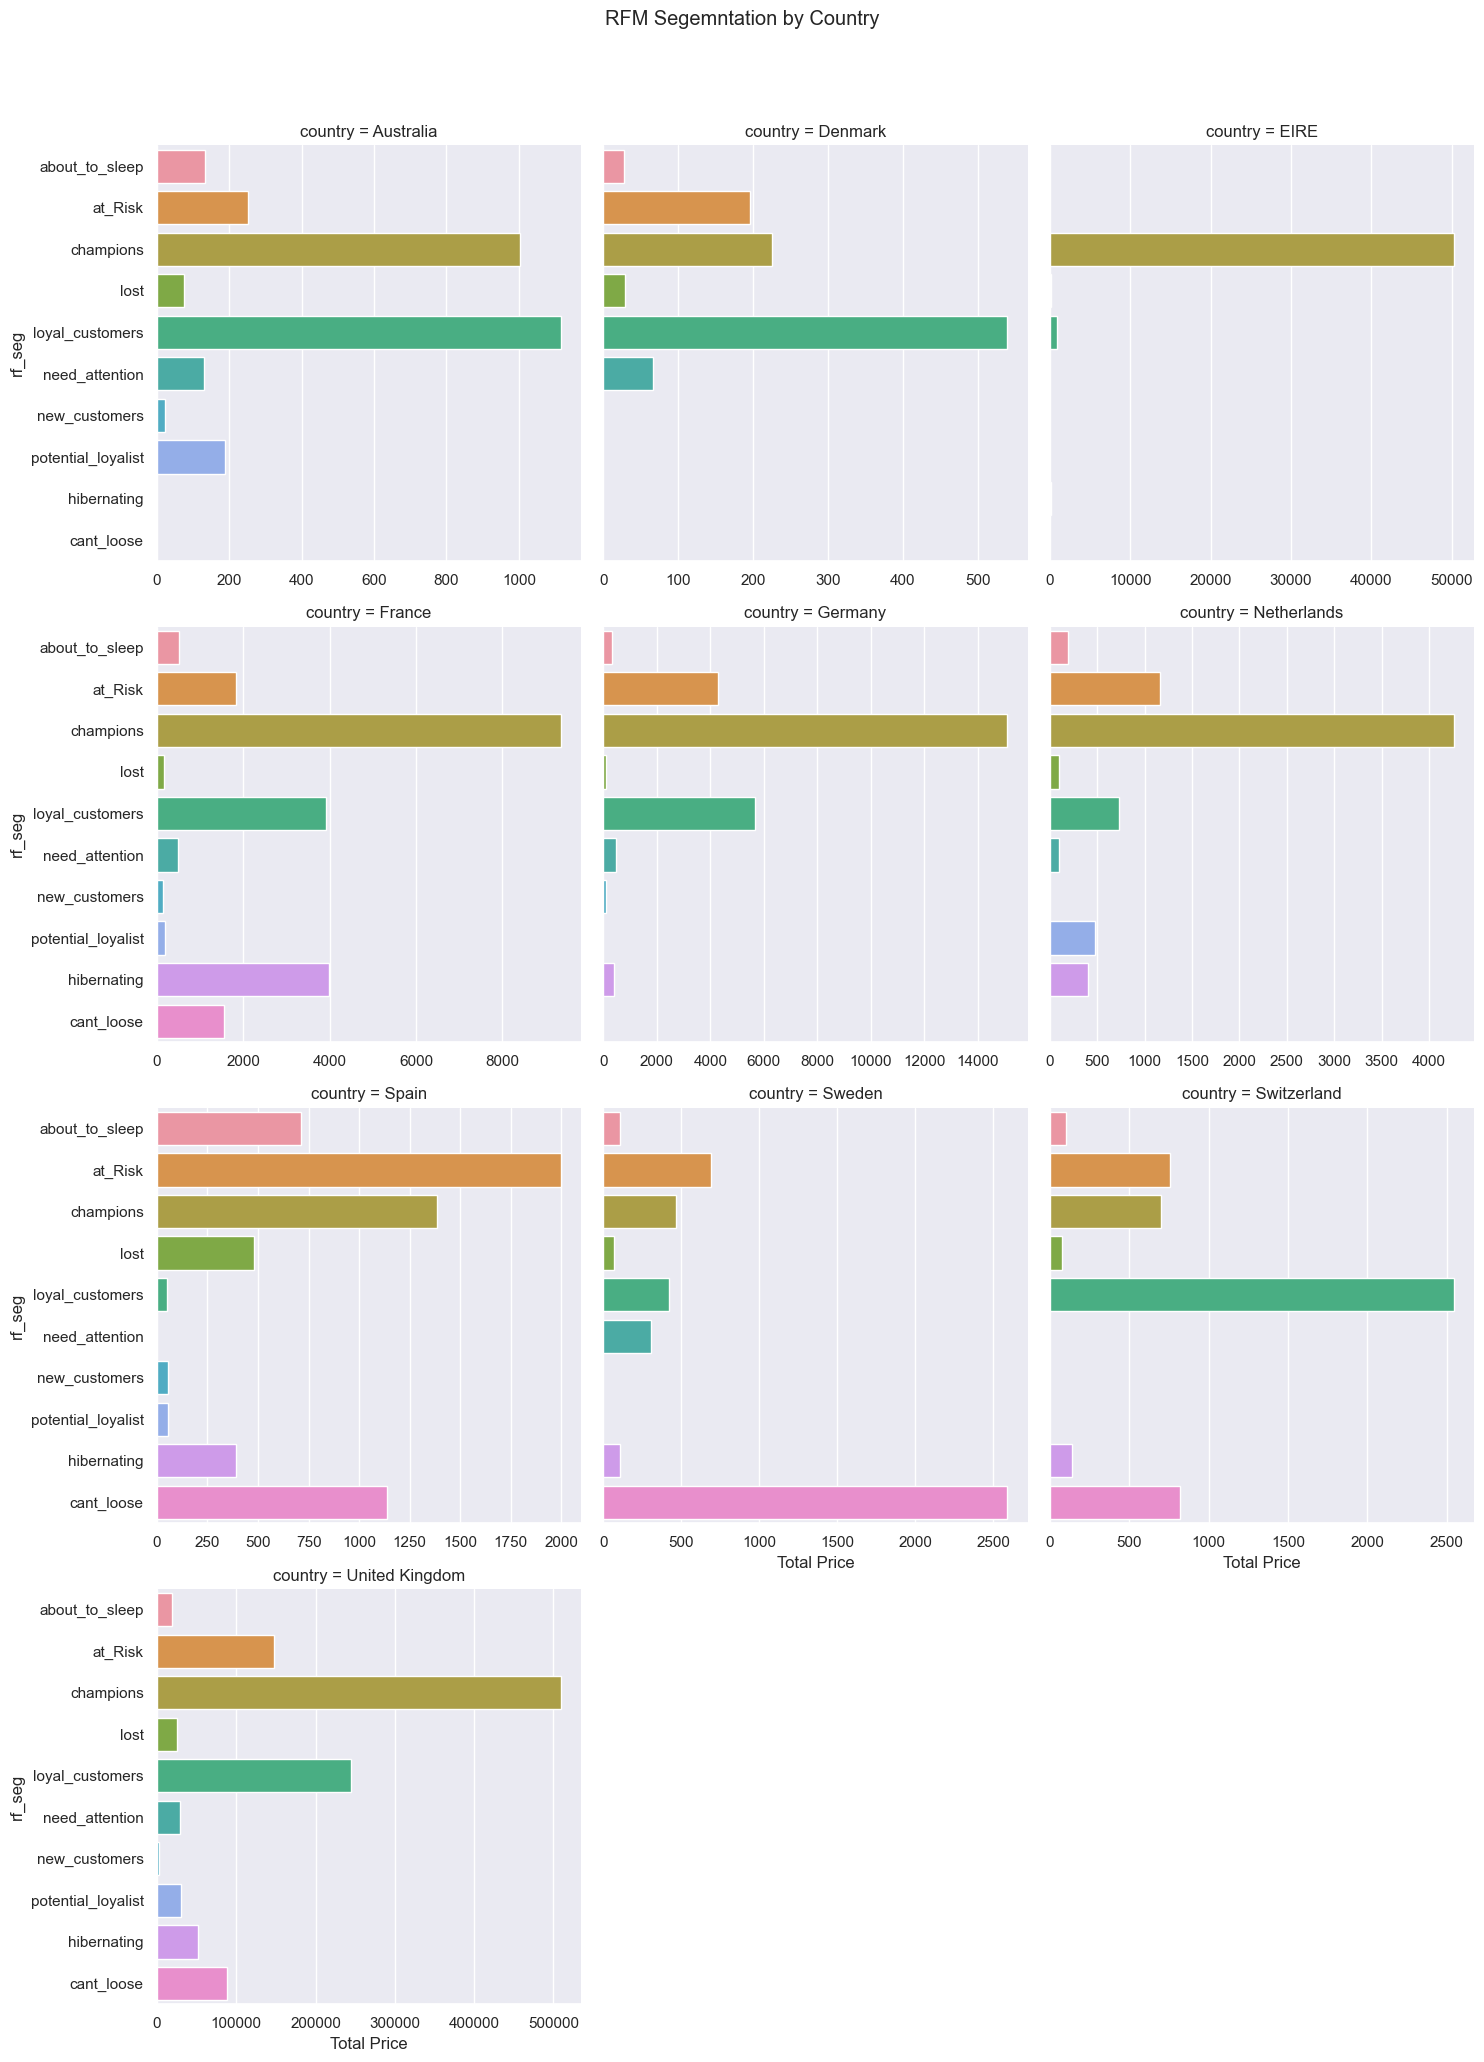

In [115]:
# group to rank by purchase price an get a list of top 10
group_price = df.groupby(['country'])['total_purchase_price'].sum().\
                        to_frame('count')

# get list
mask = group_price.sort_values('count', ascending=False).head(10).index.to_list()
# mask the df
countries = df[df['country'].isin(mask)]
countries_grouped = countries.groupby(['country', 'rf_seg'])['price'].sum().to_frame('Total Price').reset_index()

# plot a facet grid by country
sns.catplot(data = countries_grouped, x = 'Total Price', y = 'rf_seg', kind='bar', col='country', col_wrap=3,\
               sharex=False, sharey=True)
plt.suptitle('RFM Segemntation by Country', y = 1.03)
plt.tight_layout()

plt.savefig('rf_seg_by_country.png', dpi=300, bbox_inches='tight')

The plot presented above is highly complex and contains many different components, such as multiple data series, axes, and labels. Dissecting each of these components in detail could require a significant amount of time and effort, and would most likely pose several more questions. Therefore, while the plot provides valuable insights into the data, a comprehensive analysis of its components will not be provided in here.

### Conclusion


We could take this a lot further for all of the customers or certain customers. An RFM analysis provides many different angles for analysis and this didn't even require an machine learning! 

One of the key benefits of RFM analysis is that it doesn't require any machine learning or advanced statistical techniques. Instead, it relies on simple calculations and data segmentation to provide insights into customer behavior.

However, while RFM analysis is relatively straightforward to implement, it can be incredibly powerful when used effectively. For example, an RFM analysis can be used to identify high-value customers who are worth investing in to retain their loyalty and drive more revenue. It can also be used to identify customers who are at risk of churning, and to target these customers with personalized offers to encourage them to return.

Furthermore, RFM analysis can be combined with other data analysis techniques to gain even deeper insights into customer behavior. For example, it can be combined with demographic data to identify patterns in customer behavior across different age groups, genders, and geographic regions.